# Chapter 15 Generate Image Descriptions


## 0. Generate an image using Stable Diffusion

In [1]:
import torch
from diffusers import StableDiffusionPipeline
text2img_pipe = StableDiffusionPipeline.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , torch_dtype = torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

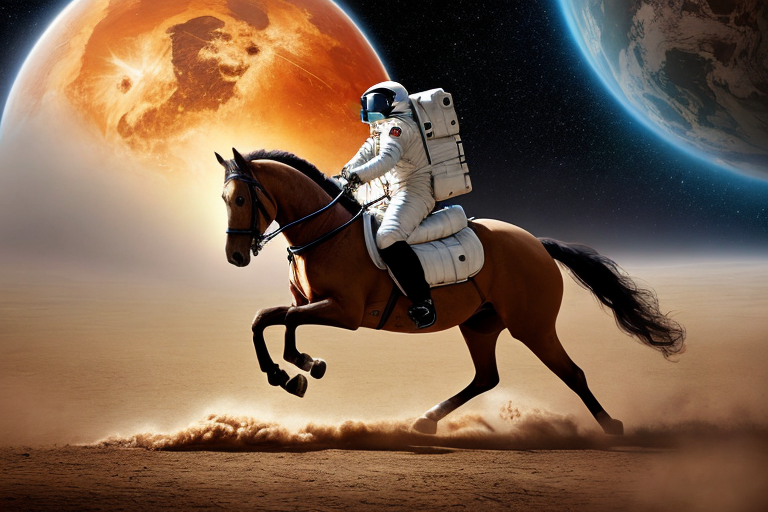

In [2]:
text2img_pipe.to("cuda:0")
prompt = "high resolution, a photograph of an astronaut riding a horse"
input_image = text2img_pipe(
    prompt = prompt,
    generator = torch.Generator("cuda:0").manual_seed(100),
    height = 512,
    width = 768
).images[0]
text2img_pipe.to("cpu")
torch.cuda.empty_cache()
input_image

## 1. BLIP-2

In [3]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
# by default `from_pretrained` loads the weights in float32
# we load in float16 instead to save memory
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b"
    , torch_dtype=torch.float16
).to(device)


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asus\.cache\huggingface\hub\models--Salesforce--blip2-opt-2.7b. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [25]:
prompt = "describe the content of the image:"
inputs = processor(
    input_image
    , text=prompt
    , return_tensors="pt"
).to(device)

generated_ids = model.generate(**inputs, max_new_tokens=768)
generated_text = processor.batch_decode(
    generated_ids
    , skip_special_tokens=True
)[0].strip()
print(generated_text)

astronaut on horseback in space


In [36]:
prompt = "how many planets in the background:"
inputs = processor(
    input_image
    , text=prompt
    , return_tensors="pt"
).to(device)

generated_ids = model.generate(**inputs, max_new_tokens=768)
generated_text = processor.batch_decode(
    generated_ids
    , skip_special_tokens=True
)[0].strip()
print(generated_text)

the universe is bigger than you think


## 2. LLaVA: Large Language and Vision Assistant

In [2]:
from llava.constants import (
    IMAGE_TOKEN_INDEX
    , DEFAULT_IMAGE_TOKEN
    , DEFAULT_IM_START_TOKEN
    , DEFAULT_IM_END_TOKEN
)
from llava.conversation import (
    conv_templates, SeparatorStyle
)
from llava.model.builder import load_pretrained_model
from llava.mm_utils import (
    process_images
    , tokenizer_image_token
    , get_model_name_from_path
    , KeywordsStoppingCriteria
)

[2023-10-18 20:59:44,414] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [4]:
# load up tokenizer, model, image_processor
model_path = "/home/andrewzhu/az_git_folder/inference_server/model_repos/llava-v1.5-7b"
model_name = get_model_name_from_path(model_path)
conv_mode = "llava_v1"
tokenizer, model, image_processor, _ = load_pretrained_model(
    model_path          = model_path
    , model_base        = None
    , model_name        = model_name
    , load_4bit         = True
    , device            = "cuda"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
user_input = "Analyze the image in a comprehensive and detailed manner"

# start a new conversation
conv = conv_templates[conv_mode].copy()

# process image to tensor 
image_tensor = process_images(
    [input_image]
    , image_processor
    , {"image_aspect_ratio":"pad"}
).to(model.device, dtype=torch.float16)

# append image place holder to the conversation
if model.config.mm_use_im_start_end:
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + user_input
else:
    inp = DEFAULT_IMAGE_TOKEN + '\n' + user_input
conv.append_message(conv.roles[0], inp)

# get the prompt for inference
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()

# convert prompt to token ids
input_ids = tokenizer_image_token(
    prompt
    , tokenizer
    , IMAGE_TOKEN_INDEX
    , return_tensors='pt'
).unsqueeze(0).cuda()

# prepare stopping criteria
stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
keywords = [stop_str]
stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)

# output the data
with torch.inference_mode():
    output_ids = model.generate(
        input_ids
        , images              =image_tensor
        , do_sample           = True
        , temperature         = 0.05
        , max_new_tokens      = 1024
        , streamer            = None
        , use_cache           = True
        , stopping_criteria   = [stopping_criteria]
    )

outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()

# make sure the conv object holds all the output
conv.messages[-1][-1] = outputs 
print(outputs)

The image features a man dressed in a white space suit, riding a horse in a desert-like environment. The man appears to be a space traveler, possibly on a mission or exploring the area. The horse is galloping, and the man is skillfully riding it.

In the background, there are two moons visible, adding to the sense of a space-themed setting. The combination of the man in a space suit, the horse, and the moons creates a captivating and imaginative scene.</s>
